In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from functools import partial
import random
from scipy import ndimage

2023-08-29 10:24:43.877791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 10:24:45.635925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/nick/miniconda3/envs/tf_env/lib/
2023-08-29 10:24:45.636124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick

In [2]:
(test_set_raw, val_set_raw, train_set_raw), info = tfds.load("tf_flowers", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True, with_info=True)

2023-08-29 10:24:47.666171: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 100%|█████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/ file]
2023-08-29 10:25:00.710168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.


Dataset tf_flowers downloaded and prepared to /home/nick/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2023-08-29 10:25:00.914677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 10:25:00.914734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 10:25:00.918287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 10:25:00.923070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_nod

In [3]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
info.splits["train"].num_examples

3670

In [4]:
def preprocess(image, label, augment=False):
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        
    image = tf.image.resize(image, [256, 256])
    image = tf.keras.layers.CenterCrop(224, 224)(image)
    image = keras.applications.xception.preprocess_input(image)
    return image, label

In [5]:
train_set = train_set_raw.map(partial(preprocess, augment=True)).batch(32).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(32).prefetch(1)
val_set = val_set_raw.map(preprocess).batch(32).prefetch(1)

In [6]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
hidden_l1 = keras.layers.Dense(256, activation="relu")(avg)
dropout = keras.layers.Dropout(rate=0.4)(hidden_l1)
output = keras.layers.Dense(n_classes, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.inputs, outputs=output)

83683744/83683744 [==============================] - 4s 0us/step


In [7]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
)

# Reduce learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
)

In [8]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [9]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * 3670 / 32),
                    validation_data=val_set,
                    validation_steps=int(0.15 * 3670 / 32),
                    epochs=5)

Epoch 1/5


2023-08-29 10:25:20.712324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-08-29 10:25:23.473318: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-29 10:25:23.473400: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-29 10:25:23.523519: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2e32f280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-29 10:25:23.523572: I tensorflow/compiler/xla/service/service.cc:181]   StreamE

86/86 [==============================] - 22s 90ms/step - loss: 0.5548 - accuracy: 0.8027 - val_loss: 0.4016 - val_accuracy: 0.8621
Epoch 2/5
86/86 [==============================] - 7s 86ms/step - loss: 0.2995 - accuracy: 0.8903 - val_loss: 0.3755 - val_accuracy: 0.8695
Epoch 3/5
86/86 [==============================] - 8s 92ms/step - loss: 0.2400 - accuracy: 0.9186 - val_loss: 0.3594 - val_accuracy: 0.8750
Epoch 4/5
86/86 [==============================] - 8s 92ms/step - loss: 0.1929 - accuracy: 0.9306 - val_loss: 0.3765 - val_accuracy: 0.8713
Epoch 5/5
86/86 [==============================] - 8s 96ms/step - loss: 0.1593 - accuracy: 0.9484 - val_loss: 0.4013 - val_accuracy: 0.8603


In [10]:
model.evaluate(test_set)

12/12 [==============================] - 2s 134ms/step - loss: 0.2803 - accuracy: 0.9101


2023-08-29 10:26:05.396226: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-29 10:26:05.396296: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


[0.28033891320228577, 0.9100817441940308]

In [11]:
history.history["accuracy"]
history.history["val_accuracy"]

[0.8621323704719543,
 0.8694853186607361,
 0.875,
 0.8713235259056091,
 0.8602941036224365]

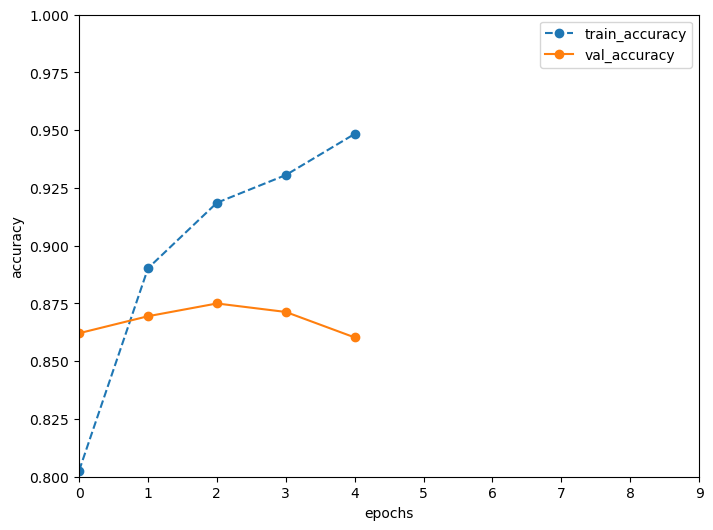

In [12]:
epochs = np.arange(5)
plt.figure(figsize=(8,6))
plt.plot(epochs,history.history["accuracy"],"o--", label="train_accuracy")
plt.plot(epochs,history.history["val_accuracy"], "o-", label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.axis([0,9,0.8,1])
plt.legend()

In [13]:
for layer in base_model.layers:
    layer.trainable = True

In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * 3670 / 32),
                    validation_data=val_set,
                    validation_steps=int(0.15 * 3670 / 32),
                    epochs=40)

Epoch 1/40


2023-08-29 10:26:19.460628: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-29 10:26:19.460703: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-29 10:26:19.484723: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-29 10:26:19.484791: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

86/86 [==============================] - 60s 304ms/step - loss: 0.4347 - accuracy: 0.8576 - val_loss: 2.5315 - val_accuracy: 0.7114
Epoch 2/40
86/86 [==============================] - 29s 335ms/step - loss: 0.2755 - accuracy: 0.9110 - val_loss: 2.2750 - val_accuracy: 0.7408
Epoch 3/40
86/86 [==============================] - 29s 342ms/step - loss: 0.2205 - accuracy: 0.9324 - val_loss: 0.8793 - val_accuracy: 0.7849
Epoch 4/40
86/86 [==============================] - 31s 362ms/step - loss: 0.2030 - accuracy: 0.9393 - val_loss: 0.4134 - val_accuracy: 0.8897
Epoch 5/40
86/86 [==============================] - 32s 369ms/step - loss: 0.1673 - accuracy: 0.9480 - val_loss: 1.0464 - val_accuracy: 0.8051
Epoch 6/40
86/86 [==============================] - 32s 371ms/step - loss: 0.1190 - accuracy: 0.9655 - val_loss: 1.0830 - val_accuracy: 0.7610
Epoch 7/40
86/86 [==============================] - 33s 381ms/step - loss: 0.1312 - accuracy: 0.9629 - val_loss: 0.3200 - val_accuracy: 0.9118
Epoch 8/40

In [15]:
model.evaluate(test_set)

12/12 [==============================] - 1s 64ms/step - loss: 0.4458 - accuracy: 0.9155


[0.4458428919315338, 0.9155313372612]